# PVPlr example
This notebook works an example of conducing some PLR analysis on DOE Regional Test Center data.

In [1]:
from pvplr.feature_correction import PLRProcessor
from pvplr.model_comparison import PLRModel
from pvplr.plr_determination import PLRDetermination

import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from sklearn import linear_model
import matplotlib.pyplot as plt

Data can be downloaded from OSF.io: https://osf.io/yvzhk/ 

In [2]:
# DATA CLEANING ------------------------------------------------------
processor = PLRProcessor()
var_list = processor.plr_build_var_list(time_var='tmst', power_var='idcp', irrad_var='poay', temp_var='modt', wind_var='wspa')
VERMONT_2 = "../data/lwcb907.csv"
raw = pd.read_csv(VERMONT_2)

IRRAD_THRESH = [0, 200, 800]
results = pd.DataFrame(index=['Reg PLR', 'Reg Error', 'YOY PLR', 'YOY Error'], columns=['0', '200', '800'])


In [7]:
for num in IRRAD_THRESH:
    # Process area dataset
    df = processor.plr_cleaning(df=raw, var_list=var_list, irrad_thresh=num, low_power_thresh=0.05, high_power_cutoff=None)
    fdf = processor.plr_saturation_removal(df=raw, var_list=var_list)

    # DATA MODELING ------------------------------------------------------
    model = PLRModel()

    # New Mexico 1
    m = model.plr_pvusa_model(df=fdf, var_list=var_list, by='week', data_cutoff=30, predict_data=None)
    no_outliers = processor.plr_remove_outlier(m)

    # PLR CALCULATION ----------------------------------------------------
    determination = PLRDetermination()


    reg = determination.plr_weighted_regression(no_outliers, power_var='power_var', time_var='time_var', model="Xbx", per_year=52, weight_var='sigma')
    yoy = determination.plr_yoy_regression(no_outliers, power_var='power_var', time_var='time_var', model="Xbx", per_year=52, return_PLR=True)

    results.loc['Reg PLR', str(num)] = reg['plr'].item()
    results.loc['Reg Error', str(num)] = reg['error'].item()
    results.loc['YOY PLR', str(num)] = yoy['plr'].item()
    results.loc['YOY Error', str(num)] = yoy['plr_sd'].item()



/Users/benpierce/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:828: RuntimeWarning: divide by zero encountered in divide
  transform = 1.0 / sigma
/Users/benpierce/git/pvplr_github/pvplr/pvplr/plr_determination.py:101: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df = pd.concat([p1.to_frame().T, p2]).loc[:, ['pvar', 'tvar']]
/Users/benpierce/git/pvplr_github/pvplr/pvplr/plr_determination.py:101: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df = pd.concat([p1.to_frame().T, p2]).loc[:, ['pvar', 'tvar']]
/Users/benpierce/git/pvplr_github/pvplr/pvplr/plr_determination.py:101: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Expl

In [9]:
results

,0,200,800
Reg PLR,-4.16,-4.16,-4.16
Reg Error,NaN,NaN,NaN
YOY PLR,-3.446334,-3.446334,-3.446334
YOY Error,55.107851,55.107851,55.107851


In [10]:
reg

,plr,error,slope,y-int,model,method
0,-4.16,NaN,-2.0,2500.0,Xbx,weighted


StopIteration: 

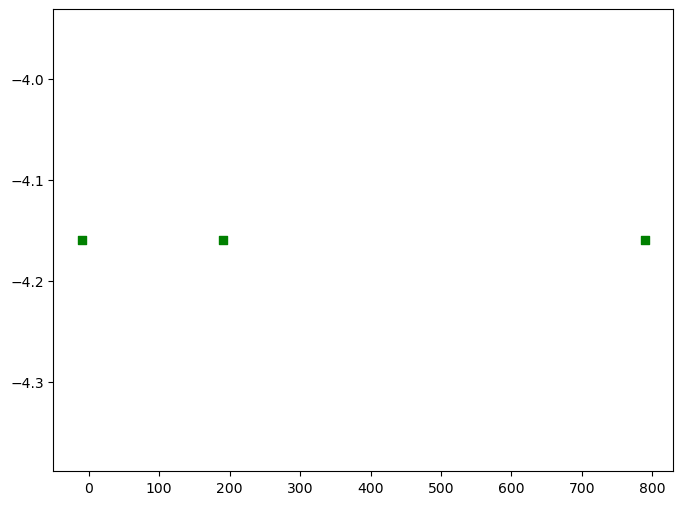

In [8]:
reg_plr = results.loc['Reg PLR']
reg_error = results.loc['Reg Error']
yoy_plr = results.loc['YOY PLR']
yoy_error = results.loc['YOY Error']

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Set the width of the bars
bar_width = 20

reg_plr.index = reg_plr.index.astype(int)
yoy_plr.index = yoy_plr.index.astype(int)

# Plot the Reg PLR values as squares
ax.scatter(reg_plr.index - bar_width/2, reg_plr, marker='s', color='green', label='Reg PLR')
ax.errorbar(reg_plr.index - bar_width/2, reg_plr, yerr=reg_error, fmt='none', capsize=4, ecolor='green', zorder=1)

# Plot the YOY PLR values as triangles
ax.scatter(yoy_plr.index + bar_width/2, yoy_plr, marker='^', color='green', label='YOY PLR')
ax.errorbar(yoy_plr.index + bar_width/2, yoy_plr, yerr=yoy_error, fmt='none', capsize=4, ecolor='green', zorder=1)

# Set the x-tick labels
ax.set_xticks(reg_plr.index)
ax.set_xticklabels(reg_plr.index)

# Display the plot
plt.tight_layout()
plt.savefig('V2_PVUSA.png')
